In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from fourier import FNO1d
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss

(1000, 2000, 7)
(1000, 2000, 5)


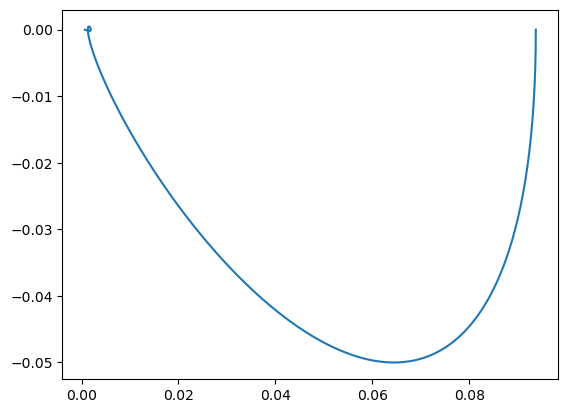

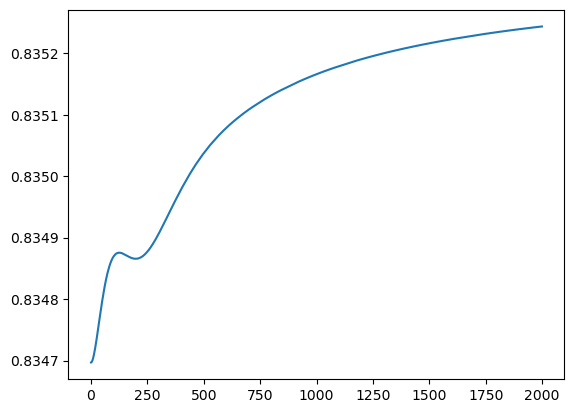

In [2]:
# Load Data

T = 20
dt = 0.01
nt = int(round(T/dt))
npoints = 1000
t1 = np.linspace(0, T, nt)
 
x = np.loadtxt("xAlpha.dat", dtype=np.float32)
x = x.reshape(
    x.shape[0], x.shape[1] // 7, 7)
y = np.loadtxt("y.dat", dtype=np.float32)
y = y.reshape(
    y.shape[0], y.shape[1] // 5, 5)

phi = x[0].transpose()[0]
p = x[0].transpose()[1]
plt.plot(phi, p)
plt.figure()
theta = y[0].transpose()
plt.plot(theta[2])

print(x.shape)
print(y.shape)



In [3]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 100
modes = 16
width = 48

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

# Normalize
x_normalizer = UnitGaussianNormalizer(x_train)
y_normalizer = UnitGaussianNormalizer(y_train)
x_train  = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)
y_train = y_normalizer.encode(y_train)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [6]:
model = FNO1d(modes, width, 7, 5).cuda()
print(count_params(model))

311669


In [7]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            out = y_normalizer.decode(out)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    if ep%50 == 0:
        print(ep, t2-t1, train_mse, test_mse)

0 2.4515108140185475 0.4426879505316416 0.15428748726844788
50 0.5644228919409215 0.03876443182428678 0.032539738714694975
100 0.5810670820064843 0.0148788972861237 0.012654302082955838
150 0.5697125990409404 0.014274702107326852 0.009106646012514829
200 0.5534731410443783 0.008526320703741578 0.010532683786004781
250 0.5901529949624091 0.013558838361253342 0.012039576936513186
300 0.621311784023419 0.007851838134229183 0.004869859246537089
350 0.617697122041136 0.006621536247742673 0.0053772137500345705
400 0.5829776090104133 0.006083256086438066 0.0038005920592695474
450 0.5722574489191175 0.005365522242047721 0.003397474903613329
500 0.5673855398781598 0.0033051207144227292 0.0024588680360466244
550 0.5735654840245843 0.002889616862456832 0.0025466158986091614
600 0.5720967948436737 0.003223266230068273 0.0024918382056057452
650 0.572385512990877 0.002645058906637132 0.00289060533978045
700 0.5688011669553816 0.002540050121024251 0.0022305799182504417
750 0.5711575008463115 0.002646

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


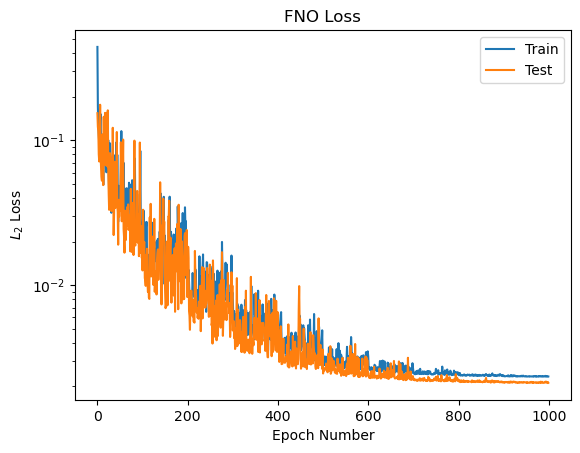

In [14]:
plt.title("FNO Loss")
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig('fno.eps')

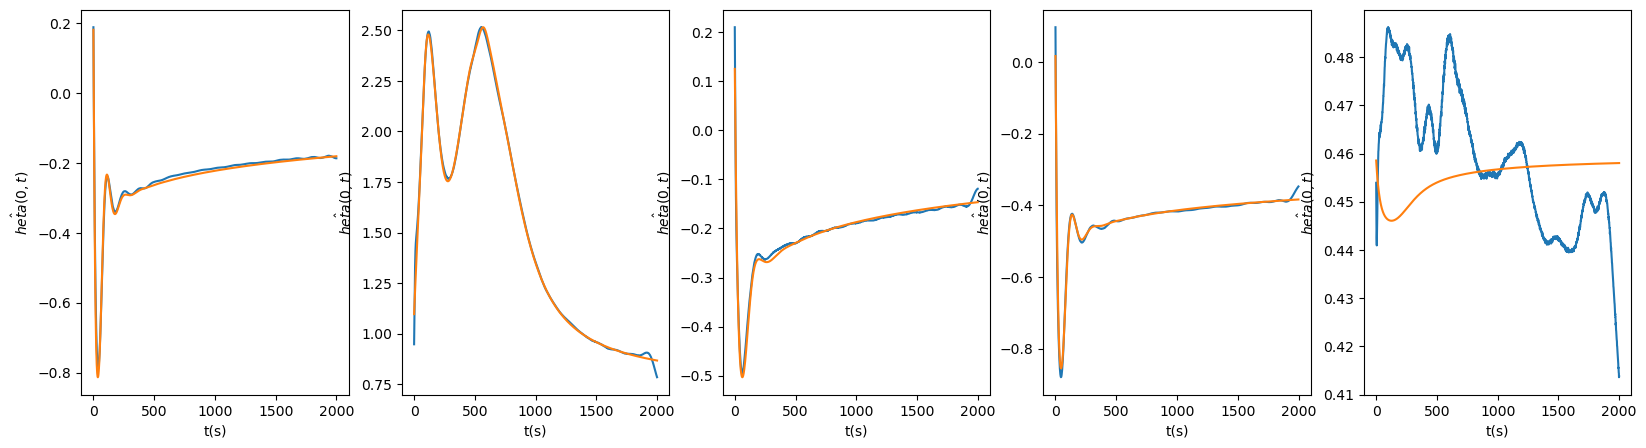

In [15]:
# Show some examples at the boundry
index = 0
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda() 
        out = model(x)
        out = y_normalizer.decode(out)
        l1 = ax[index].plot(out[0,:, 0].detach().cpu(), label="Neural Network Model")
        l2 = ax[index].plot(y[0, :, 0].detach().cpu(), label="Statistical Parameter Estimator")
        ax[index].set_xlabel("t(s)")
        ax[index].set_ylabel("$\hat{\theta}(0, t)$")
        index+=1
#fig.legend([l1, l2], ["Neural Network Model", "Statistical Parameter Estimator"])
#fig.show()

In [16]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
            
        out = model(x)
        out = y_normalizer.decode(out)


        test_mse += loss(out, y).item()
print("TEST MSE For " + str(batch_size) + " Instances:", test_mse/len(testData))

TEST MSE For 20 Instances: 0.0021206951001659035


In [7]:
model.load_state_dict(torch.load('fnoModel1'))

<All keys matched successfully>

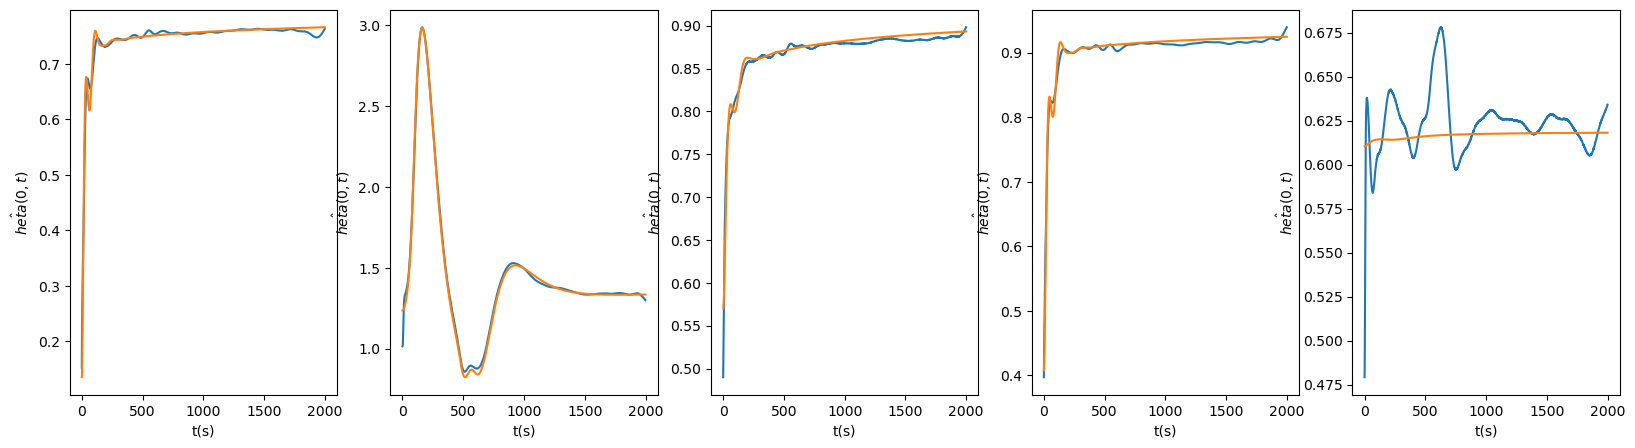

In [13]:
# Show some examples at the boundry
index = 0
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x)
        out = y_normalizer.decode(out)
        l1 = ax[index].plot(out[0,:, 2].detach().cpu(), label="Neural Network Model")
        l2 = ax[index].plot(y[0, :, 2].detach().cpu(), label="Statistical Parameter Estimator")
        ax[index].set_xlabel("t(s)")
        ax[index].set_ylabel("$\hat{\theta}(0, t)$")
        index+=1
#fig.legend([l1, l2], ["Neural Network Model", "Statistical Parameter Estimator"])
#fig.show()

In [8]:
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        startTime = default_timer()
        out = model(x)
        out = y_normalizer.decode(out)
        endTime = default_timer()

In [9]:
print(endTime-startTime)

0.0012653088197112083
